In [1]:
import pandas as pd
from pandas import Timestamp
from pandas.tseries.offsets import BDay
import numpy as np
from scipy.interpolate import interp1d
import os
import re
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

# 1. Import datasets

In [2]:
# nip
nip = pd.read_csv('nip_peers_settlement.csv', index_col=0)

In [3]:
# new issues features
new_issues_features = pd.read_csv('new_issues.csv', index_col=0)

In [4]:
# new issues characteristics
new_issues_characteristics = pd.read_csv('new_issues_characteristics.csv', index_col=0)

In [5]:
# initial spread to peers
spread_to_peers = pd.read_csv('spread_to_peers.csv', index_col=0)

In [6]:
# Index data
iboxx_overall = pd.read_csv('iboxx_overall.csv', sep=';')
move_index = pd.read_csv('move_index.csv')
swap_rates = pd.read_csv('swap_rates.csv', index_col=0)

In [7]:
new_issues_features['dealDate'] = pd.to_datetime(new_issues_features['dealDate'])
new_issues_features['dealDate'] = new_issues_features['dealDate'].dt.floor('d')

In [8]:
# Extract the column names and their corresponding years
columns = swap_rates.columns
years = []

# Determine if the column represents months or years and extract the corresponding number
for col in columns:
    match = re.search(r'(\d+)([YM])=', col)
    if match:
        num = int(match.group(1))
        unit = match.group(2)
        if unit == 'Y':
            years.append(num)
        elif unit == 'M':
            years.append(num / 12)
            
# Create a dictionary to map the old column names to the new column names
new_columns = {col: yr for col, yr in zip(columns, years)}

# Rename the columns in the DataFrame
swap_rates.rename(columns=new_columns, inplace=True)

# Sort the columns in ascending order
swap_rates = swap_rates.reindex(sorted(swap_rates.columns), axis=1)

# Change time type in refinitive prices dataset
swap_rates = swap_rates.reset_index()
swap_rates['Date'] = pd.to_datetime(swap_rates['Date'])
swap_rates['Date'] = swap_rates['Date'].dt.date
swap_rates['Date'] = swap_rates['Date'].astype('datetime64')
swap_rates['Date'] = swap_rates['Date'].dt.floor('d')
swap_rates = swap_rates.set_index('Date')

In [9]:
# Calculate the corresponding swap rates for bonds
def calculate_swap_rate_bond(row):
    try:
        return interpolated_swap_rates[row['dealDate']](row['maturityTerm'])
    except KeyError:
        return None

In [10]:
# Extract the maturities from column names
maturities = [col for col in swap_rates.columns]

# Interpolate the swap rate curve for each timestamp
interpolated_swap_rates = {}
for timestamp, row in swap_rates.iterrows():
    swap_rate_interpolator = interp1d(maturities, row, kind='cubic')
    interpolated_swap_rates[timestamp] = swap_rate_interpolator

# 2.  Drivers

## 2.1 Initial spread to MS (Mid Swap)

In [11]:
# Merge initial spread
nip_ipt = nip.merge(new_issues_features[['dealDate','securities_isin', 'ipt_price_down', 'ipt_price_up', 'guidance_price_down', 'guidance_price_up']], left_on='isin', right_on='securities_isin', how='inner')
nip_ipt = nip_ipt.drop('securities_isin', axis=1)
nip_ipt = nip_ipt.reset_index(drop=True)

In [12]:
# Calculate average
nip_ipt['ipt'] = (nip_ipt['ipt_price_down'] + nip_ipt['ipt_price_up']) / 2
nip_ipt['guidance'] = (nip_ipt['guidance_price_down'] + nip_ipt['guidance_price_up']) / 2

In [13]:
# Initial spread is ipt, otherwise guidance
nip_ipt['initialSpreadToSwap'] = nip_ipt['ipt'].fillna(nip_ipt['guidance'])
nip_ipt['initialSpreadToSwap'] = nip_ipt['initialSpreadToSwap'] / 100

In [14]:
# Drop unnecessary columns
nip_ipt = nip_ipt.drop(['ipt_price_down', 'ipt_price_up', 'guidance_price_down', 'guidance_price_up'], axis=1)

<Figure size 576x432 with 0 Axes>

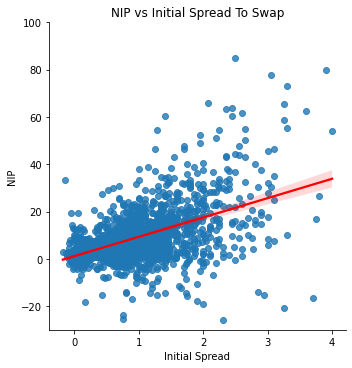

In [15]:
color_palette = sns.color_palette(["#3B5998", "#AAB8C2"])
plt.figure(figsize=(8, 6))   
sns.lmplot(x='initialSpreadToSwap', y='NIP', data=nip_ipt, line_kws={'color': 'red'}, palette=color_palette)
plt.ylim(-30, 100)
plt.xlabel('Initial Spread', fontsize=10)
plt.ylabel('NIP', fontsize=10)
plt.title('NIP vs Initial Spread To Swap')
plt.show()

## 2.2 YTM (Coupon) sread to Swap Rate

In [16]:
# Merge coupon and maturity
nip_spread = nip_ipt.merge(new_issues_features[['securities_isin', 'coupon', 'maturityTerm']], left_on='isin', right_on='securities_isin', how='inner')
nip_spread = nip_spread.drop('securities_isin', axis=1)
nip_spread = nip_spread.reset_index(drop=True)

In [17]:
nip_spread_filt = nip_spread[nip_spread['coupon'] < 10].copy()

In [18]:
# Calculate swap rate
nip_spread_filt['swapRate'] = nip_spread.apply(calculate_swap_rate_bond, axis=1)

In [19]:
# Calculate swap spread
nip_spread_filt['spreadToSwap'] = (nip_spread_filt['coupon'] - nip_spread_filt['swapRate']) * 100

In [20]:
nip_spread_filt['spreadToSwap'] = nip_spread_filt['spreadToSwap'].astype('float')
nip_spread_filt['spreadToSwap'] = nip_spread_filt['spreadToSwap'] / 100

In [21]:
# Drop unnecessary columns
nip_spread_filt = nip_spread_filt.drop(['swapRate'], axis=1)

<Figure size 576x432 with 0 Axes>

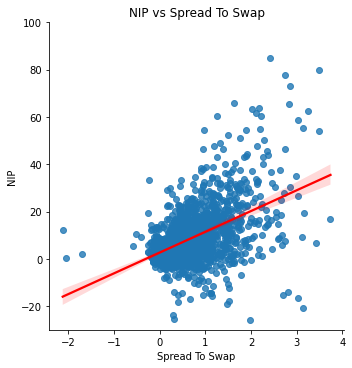

In [22]:
color_palette = sns.color_palette(["#3B5998", "#AAB8C2"])
plt.figure(figsize=(8, 6))   
sns.lmplot(x='spreadToSwap', y='NIP', data=nip_spread_filt, line_kws={'color': 'red'}, palette=color_palette)
plt.ylim(-30, 100)
plt.xlabel('Spread To Swap', fontsize=10)
plt.ylabel('NIP', fontsize=10)
plt.title('NIP vs Spread To Swap')
plt.show()

## 2.3 Spread To Peers

In [23]:
nip_diff = nip_spread_filt.merge(spread_to_peers, on='isin', how='inner')

In [24]:
nip_diff['spreadToPeers'] = nip_diff['spreadToPeers'] / 100
nip_diff = nip_diff.rename(columns={'spreadToPeers': 'spreadDiscount'})

<Figure size 576x432 with 0 Axes>

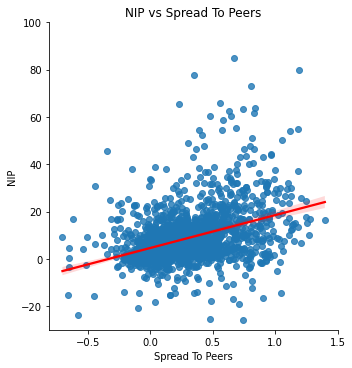

In [25]:
color_palette = sns.color_palette(["#3B5998", "#AAB8C2"])
plt.figure(figsize=(8, 6))   
sns.lmplot(x='spreadDiscount', y='NIP', data=nip_diff, line_kws={'color': 'red'}, palette=color_palette)
plt.ylim(-30, 100)
plt.xlabel('Spread To Peers', fontsize=10)
plt.ylabel('NIP', fontsize=10)
plt.title('NIP vs Spread To Peers')
plt.show()

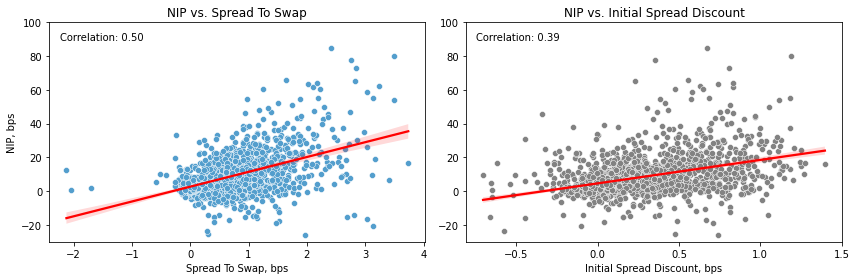

In [26]:
# Custom color palette with a lighter blue
color_palette = sns.color_palette("Blues")
grey_palette = sns.color_palette("Greys")

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left subplot
sns.scatterplot(x='spreadToSwap', y='NIP', data=nip_spread_filt, ax=ax1, color=color_palette[3])
sns.regplot(x='spreadToSwap', y='NIP', data=nip_spread_filt, ax=ax1, scatter=False, color='red')
ax1.set_ylim(-30, 100)
ax1.set_xlabel('Spread To Swap, bps', fontsize=10)
ax1.set_ylabel('NIP, bps', fontsize=10)
ax1.set_title('NIP vs. Spread To Swap')

# Calculate correlation coefficient for the left subplot
corr_left = nip_spread_filt['spreadToSwap'].corr(nip_spread_filt['NIP'])
corr_label_left = f'Correlation: {corr_left:.2f}'
ax1.text(0.25, 0.92, corr_label_left, transform=ax1.transAxes, ha='right', fontsize=10, color='black')

# Right subplot
sns.scatterplot(x='spreadDiscount', y='NIP', data=nip_diff, ax=ax2, color=grey_palette[3])
sns.regplot(x='spreadDiscount', y='NIP', data=nip_diff, ax=ax2, scatter=False, color='red')
ax2.set_ylim(-30, 100)
ax2.set_xlabel('Initial Spread Discount, bps', fontsize=10)
ax2.set_ylabel('', fontsize=10)
ax2.set_title('NIP vs. Initial Spread Discount')

# Calculate correlation coefficient for the right subplot
corr_right = nip_diff['spreadDiscount'].corr(nip_diff['NIP'])
corr_label_right = f'Correlation: {corr_right:.2f}'
ax2.text(0.25, 0.92, corr_label_right, transform=ax2.transAxes, ha='right', fontsize=10, color='black')

# Adjust the layout to prevent overlapping
plt.tight_layout()
# plt.savefig('nip_spreads.png', facecolor='w', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


## 2.4 Maturity

In [27]:
nip_maturity = nip_diff

In [28]:
maturity_bins = [0, 3, 6, 10, 30]
maturity_labels = ['1-3', '3-6', '6-10', '>10']

In [29]:
nip_maturity['maturity_bucket'] = pd.cut(nip_maturity['maturityTerm'], bins=maturity_bins, labels=maturity_labels)

In [30]:
nip_maturity['maturityTermLog'] = np.log(nip_maturity['maturityTerm'])

In [31]:
average_nip = nip_maturity.groupby('maturity_bucket')['NIP'].mean().reset_index()

In [32]:
nip_maturity = nip_maturity.drop(['maturity_bucket'], axis=1)

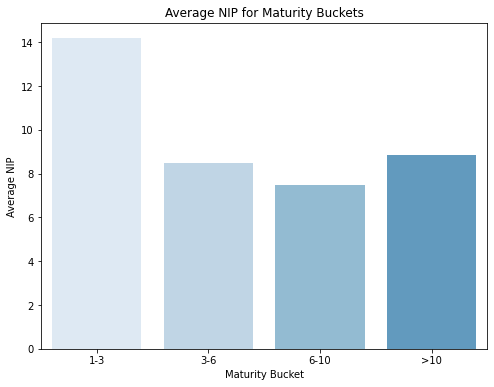

In [33]:
color_palette = sns.color_palette("Blues")
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(x='maturity_bucket', y='NIP', data=average_nip, palette=color_palette)
plt.xlabel('Maturity Bucket', fontsize=10)
plt.ylabel('Average NIP', fontsize=10)
plt.title('Average NIP for Maturity Buckets')
plt.show()

## 2.5 Corporate vs Financials

In [34]:
# Merge issuer type
nip_type = nip_maturity.merge(new_issues_features[['securities_isin', 'issuerType']], left_on='isin', right_on='securities_isin', how='inner')
nip_type = nip_type.drop('securities_isin', axis=1)
nip_type = nip_type.reset_index(drop=True)

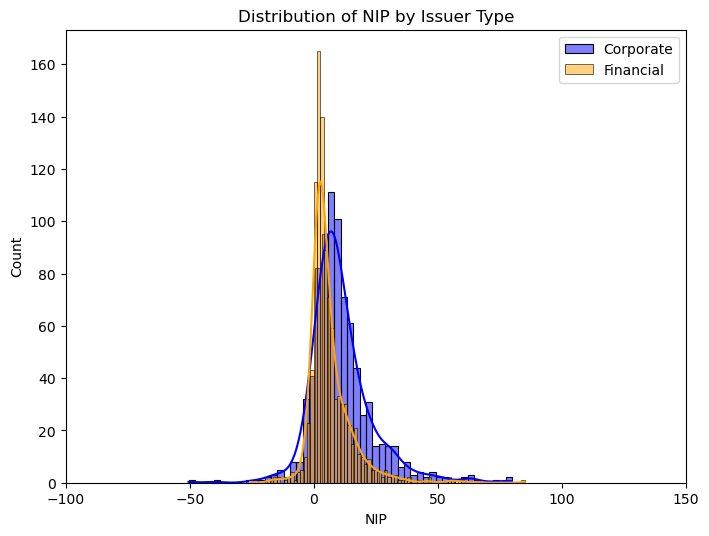

In [35]:
# Filter the DataFrame for different bond types
df_corporate = nip_type[nip_type['issuerType'] == 'Corporate']
df_financial = nip_type[nip_type['issuerType'] == 'Financials']

plt.figure(figsize=(8, 6), dpi=100)

# Plot histogram and KDE for corporate bonds
sns.histplot(data=df_corporate, x='NIP', kde=True, label='Corporate', color='blue', alpha=0.5, stat='count')

# Plot histogram and KDE for financial bonds
sns.histplot(data=df_financial, x='NIP', kde=True, label='Financial', color='orange', alpha=0.5, stat='count')

plt.xlabel('NIP', fontdict={'fontsize': 10})
plt.ylabel('Count', fontdict={'fontsize': 10})
plt.title('Distribution of NIP by Issuer Type', fontdict={'fontsize': 12})
plt.legend()

plt.xlim(-100, 150)

plt.show()

## 2.6 ESG

In [36]:
# Merge issuer type
nip_esg = nip_type.merge(new_issues_features[['securities_isin', 'esgType']], left_on='isin', right_on='securities_isin', how='inner')
nip_esg = nip_esg.drop('securities_isin', axis=1)
nip_esg = nip_esg.reset_index(drop=True)

In [37]:
# Create 'esgBond' column based on 'esgType'
nip_esg['esgBond'] = nip_esg['esgType'].notnull().astype(int)
nip_esg = nip_esg.drop(['esgType'], axis=1)

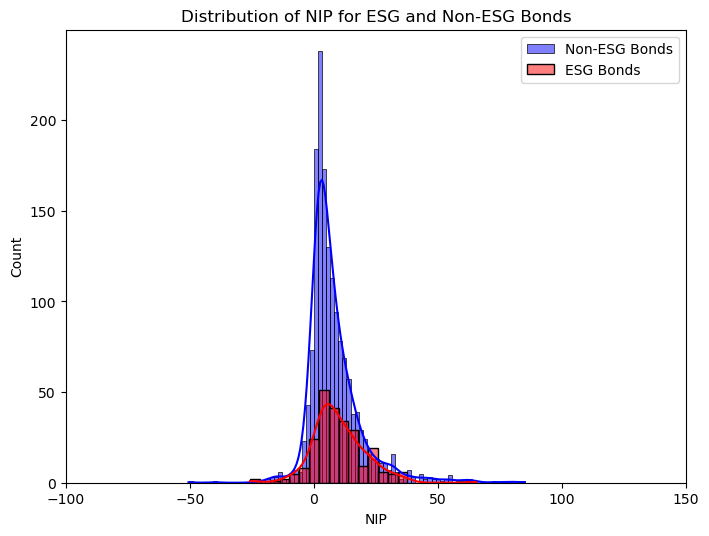

In [38]:
# Separate ESG and non-ESG bonds
esg_bonds = nip_esg[nip_esg['esgBond'] == 1]
non_esg_bonds = nip_esg[nip_esg['esgBond'] == 0]

plt.figure(figsize=(8, 6), dpi=100)

# Plot distribution of non-ESG bonds
sns.histplot(data=non_esg_bonds, x='NIP', kde=True, color='blue', label='Non-ESG Bonds', alpha=0.5)

# Plot distribution of ESG bonds
sns.histplot(data=esg_bonds, x='NIP', kde=True, color='red', label='ESG Bonds')

plt.xlabel('NIP')
plt.ylabel('Count')
plt.title('Distribution of NIP for ESG and Non-ESG Bonds')
plt.legend()

plt.xlim(-100, 150)

plt.show()

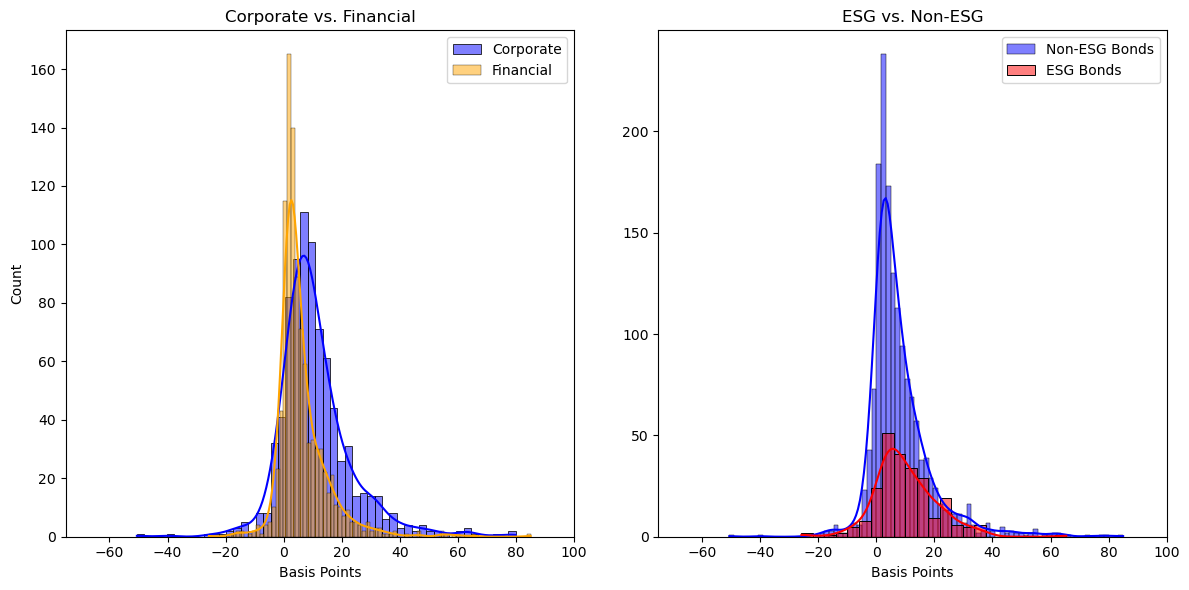

In [39]:
# Filter the DataFrame for different bond types
df_corporate = nip_type[nip_type['issuerType'] == 'Corporate']
df_financial = nip_type[nip_type['issuerType'] == 'Financials']

# Separate ESG and non-ESG bonds
esg_bonds = nip_esg[nip_esg['esgBond'] == 1]
non_esg_bonds = nip_esg[nip_esg['esgBond'] == 0]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Plot histogram and KDE for corporate bonds on the left subplot
sns.histplot(data=df_corporate, x='NIP', kde=True, label='Corporate', color='blue', alpha=0.5, stat='count', ax=axes[0])
axes[0].set_xlabel('Basis Points', fontdict={'fontsize': 10})
axes[0].set_ylabel('Count', fontdict={'fontsize': 10})
axes[0].set_title('Corporate vs. Financial', fontdict={'fontsize': 12})
axes[0].legend()
axes[0].set_xlim(-75, 100)

# Plot histogram and KDE for financial bonds on the left subplot
sns.histplot(data=df_financial, x='NIP', kde=True, label='Financial', color='orange', alpha=0.5, stat='count', ax=axes[0])
axes[0].legend()

# Plot histogram and KDE for non-ESG bonds on the right subplot
sns.histplot(data=non_esg_bonds, x='NIP', kde=True, label='Non-ESG Bonds', color='blue', alpha=0.5, ax=axes[1])
axes[1].set_xlabel('Basis Points', fontdict={'fontsize': 10})
axes[1].set_ylabel(' ', fontdict={'fontsize': 10})
axes[1].set_title('ESG vs. Non-ESG', fontdict={'fontsize': 12})
axes[1].legend()
axes[1].set_xlim(-75, 100)

# Plot histogram and KDE for ESG bonds on the right subplot
sns.histplot(data=esg_bonds, x='NIP', kde=True, label='ESG Bonds', color='red', alpha=0.5, ax=axes[1])

axes[1].legend()

plt.tight_layout()  # Adjust spacing between subplots
# plt.savefig('nip_distribution_corporate_esg.png', facecolor='w', dpi=300, bbox_inches='tight')

plt.show()

In [40]:
nip_esg = nip_esg.drop(['esgBond'], axis=1)

## 2.6 Payment rank

In [41]:
# Merge payment rank
nip_rank = nip_esg.merge(new_issues_characteristics[['isin','PAYMENT_RANK']], on='isin', how='inner')
nip_rank = nip_rank.rename(columns={'PAYMENT_RANK': 'paymentRank'})
nip_rank = nip_rank.reset_index(drop=True)

In [42]:
nip_rank = nip_rank[~nip_rank['paymentRank'].isin(['Subordinated', '1st lien', 'Unsecured'])]

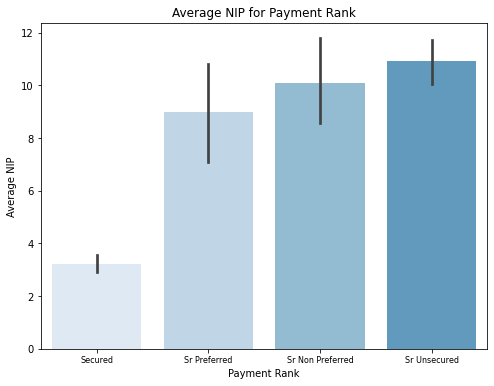

In [43]:
color_palette = sns.color_palette("Blues")
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(x='paymentRank', y='NIP', data=nip_rank, palette=color_palette)
plt.xlabel('Payment Rank', fontsize=10)
plt.ylabel('Average NIP', fontsize=10)
plt.title('Average NIP for Payment Rank')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.show()

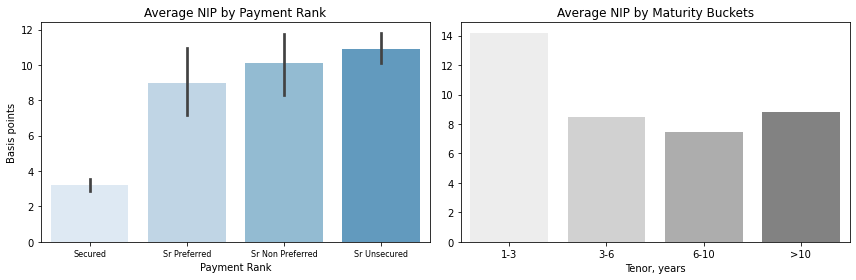

In [44]:
# Creating the left subplot
grey_palette = sns.color_palette("Greys")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # (num_rows, num_cols, subplot_number)
ax1 = sns.barplot(x='paymentRank', y='NIP', data=nip_rank, palette=color_palette)
plt.xlabel('Payment Rank', fontsize=10)
plt.ylabel('Basis points', fontsize=10)
plt.title('Average NIP by Payment Rank')
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=8)

# Creating the right subplot
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='maturity_bucket', y='NIP', data=average_nip, palette=grey_palette)
plt.xlabel('Tenor, years', fontsize=10)
plt.ylabel('', fontsize=10)
plt.title('Average NIP by Maturity Buckets')

plt.tight_layout()  # Ensures the subplots do not overlap
# plt.savefig('average_nip_rank_tenor.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

## 2.7 Issue size

In [45]:
# Merge payment size
nip_size = nip_rank.merge(new_issues_characteristics[['isin','AMT_ISSUED']], on='isin', how='inner')
nip_size = nip_size.rename(columns={'AMT_ISSUED': 'issueSize'})
nip_size = nip_size.reset_index(drop=True)

In [46]:
# Convert to mln and take log
nip_size['issueSize'] = nip_size['issueSize'] / 1000000
nip_size['issueSizeLog'] = np.log(nip_size['issueSize'])

In [47]:
# nip_size['issueSizeSqrd'] = nip_size['issueSize'] ** 2

In [48]:
# Count the occurrences of each size
size_counts = nip_size['issueSize'].value_counts().reset_index()
size_counts.columns = ['issueSize', 'count']

# Filter the sizes that appear more than 20 times
filtered_sizes = size_counts[size_counts['count'] > 10]['issueSize']

# Filter the dataframe based on the filtered sizes
filtered_df = nip_size[nip_size['issueSize'].isin(filtered_sizes)]

# Calculate the average NIP for each size
avg_nip_sizes = filtered_df.groupby('issueSize')['NIP'].median().reset_index()

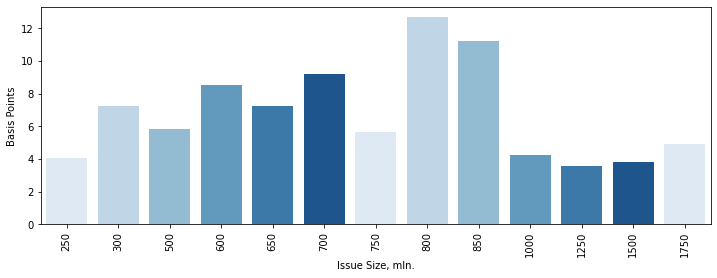

In [49]:
color_palette = sns.color_palette("Blues")
plt.figure(figsize=(12, 4))  
sns.barplot(x='issueSize', y='NIP', data=avg_nip_sizes, palette=color_palette)
plt.xlabel('Issue Size, mln.')
plt.ylabel('Basis Points')
# plt.title('Average NIP for Sizes (Count > 20)')
# Modify the x-axis tick labels
plt.xticks(rotation=90) # Rotate tick labels if needed
plt.gca().set_xticklabels([int(float(tick.get_text())) for tick in plt.gca().get_xticklabels()])
# plt.savefig('issue_size.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

## 2.8 Issue rating

In [50]:
# Merge initial spread
nip_rating = nip_size.merge(new_issues_features[['securities_isin', 'moodys', 'sp', 'fitch']], left_on='isin', right_on='securities_isin', how='inner')
nip_rating = nip_rating.drop('securities_isin', axis=1)
nip_rating = nip_rating.reset_index(drop=True)

In [51]:
# Mapping dictionary for rating conversion
ratings = {
        "Aaa": "AAA",
        "Aa1": "AA+",
        "Aa2": "AA",
        "Aa3": "AA-",
        "A1": "A+",
        "A2": "A",
        "A3": "A-",
        "Baa1": "BBB+",
        "Baa2": "BBB",
        "Baa3": "BBB-",
        "Ba1": "BB+",
        "Ba2": "BB",
        "Ba3": "BB-",
        "B1": "B+",
        "B2": "B",
        "B3": "B-",
        "Caa1": "CCC+",
        "Caa2": "CCC",
        "Caa3": "CCC-",
        "Ca": "CC",
        "C": "C",
        "WR": "NR",
        "NR": "NR",
        "AAA": "AAA",
        "AA+": "AA+",
        "AA": "AA",
        "AA-": "AA-",
        "A+": "A+",
        "A": "A",
        "A-": "A-",
        "BBB+": "BBB+",
        "BBB": "BBB",
        "BBB-": "BBB-",
        "BB+": "BB+",
        "BB": "BB",
        "BB-": "BB-",
        "B+": "B+",
        "B": "B",
        "B-": "B-",
        "CCC+": "CCC+",
        "CCC": "CCC",
        "CCC-": "CCC-",
        "CC": "CC",
        "C": "C",
        "RD": "D",
        "D": "D",
        "NR": "NR"
}

def convert_to_sp(rating):
    if pd.notna(rating):
        return ratings.get(rating, rating)
    return rating

In [52]:
nip_rating['rating'] = np.where(~nip_rating['sp'].isna(), nip_rating['sp'],
                        np.where(~nip_rating['fitch'].isna(), nip_rating['fitch'], nip_rating['moodys']))

In [53]:
nip_rating['rating'] = nip_rating['rating'].apply(convert_to_sp)

In [54]:
nip_rating['rating'] = nip_rating['rating'].fillna('NR')

In [55]:
# Drop unnecessary columns
nip_rating = nip_rating.drop(['moodys', 'sp', 'fitch'], axis=1)

In [56]:
rating_order = [
    "AAA", "AA+", "AA", "AA-", "A+", "A", "A-", 
    "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", 
    "B+", "B", "B-", "CCC+", "CCC", "CCC-", 
    "CC", "C", "D"
]

In [57]:
sorted_nip_rating = nip_rating.sort_values('rating', key=lambda x: x.map({v: i for i, v in enumerate(rating_order)}))

In [58]:
sorted_nip_rating = sorted_nip_rating[sorted_nip_rating['rating']!='WR']

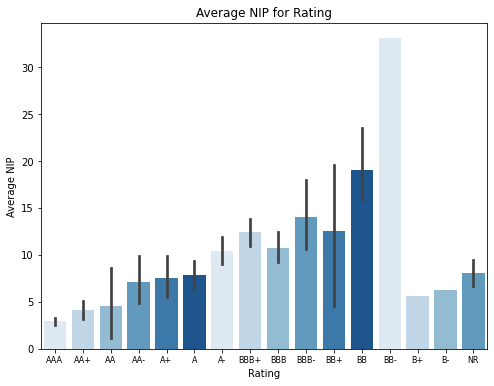

In [59]:
color_palette = sns.color_palette("Blues")
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(x='rating', y='NIP', data=sorted_nip_rating, palette=color_palette)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Average NIP', fontsize=10)
plt.title('Average NIP for Rating')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.show()

## 2.9 Demand factors

In [60]:
# Convert the "dealDate" column to datetime format
nip_deals = nip_rating.copy()

# Set 'date' column as the DataFrame index
nip_deals['dealDate'] = pd.to_datetime(nip_deals['dealDate'])
nip_deals.set_index('dealDate', inplace=True)

In [61]:
# Calculate monthly average NIP
monthly_avg = nip_deals['NIP'].resample('M').mean()

## 2.9.1 Index spread

In [62]:
iboxx_overall_oas = iboxx_overall[['Download_Date', 'OAS']].copy()
iboxx_overall_oas['Download_Date'] = pd.to_datetime(iboxx_overall_oas['Download_Date'])

In [63]:
iboxx_overall_z = iboxx_overall[['Download_Date', 'Z_Spread_Over_Libor']].copy()
iboxx_overall_z['Download_Date'] = pd.to_datetime(iboxx_overall_z['Download_Date'])

In [64]:
iboxx_overall_oas.set_index('Download_Date', inplace=True)

In [65]:
iboxx_overall_z.set_index('Download_Date', inplace=True)

In [66]:
# OAS inside sample range
start_date = monthly_avg.index.min()
end_date = monthly_avg.index.max()
oas_values = iboxx_overall_oas.loc[start_date:end_date, 'OAS']

In [67]:
# Z-spread inside sample range
z_values = iboxx_overall_z.loc[start_date:end_date, 'Z_Spread_Over_Libor']

In [68]:
# Calculate average NIP for each date in nip_deals
nip_deals_avg = nip_deals.groupby(nip_deals.index).mean()

# Merge dataframes based on dates and filter by iboxx_overall_z dates > nip_deals dates
merged_df = pd.merge(iboxx_overall_z, nip_deals_avg, left_index=True, right_index=True, how='inner')

# Calculate the correlation and its p-value
correlation, p_value = pearsonr(merged_df['Z_Spread_Over_Libor'], merged_df['NIP'])

print("Correlation:", correlation)
print("P-value:", p_value)

Correlation: 0.1849022355111284
P-value: 4.887891362382859e-07


In [69]:
# Calculate average NIP for each month in nip_deals
nip_deals_monthly_avg = nip_deals.resample('M').mean()

# Calculate average zSpread for each month in iboxx_overall_z
iboxx_overall_z_monthly_avg = iboxx_overall_z.resample('M').mean()

# Merge the two dataframes based on the month
merged_df = pd.merge(iboxx_overall_z_monthly_avg, nip_deals_monthly_avg, left_index=True, right_index=True, how='inner')

# Drop rows with NaN values
merged_df.dropna(inplace=True)

# Calculate the correlation and its p-value
correlation, p_value = pearsonr(merged_df['Z_Spread_Over_Libor'], merged_df['NIP'])

print("Correlation:", correlation)
print("P-value:", p_value)

Correlation: 0.44466456057786374
P-value: 0.00011499296796891834


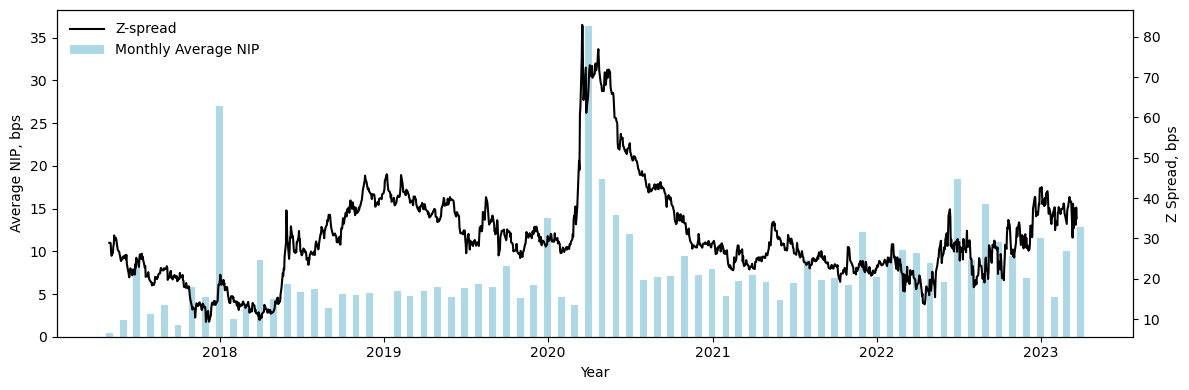

In [70]:
# Create a subplot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 4), dpi=100)

# Create a secondary y-axis on the right side for the monthly average NIP
ax2 = ax1.twinx()
avg_nip_bar = ax1.bar(monthly_avg.index, monthly_avg, color='lightblue', width=15)
ax1.set_ylabel('Average NIP, bps')

# Plot the Z Spread values as a line with black color using the left y-axis
zspread_line, = ax2.plot(z_values.index, z_values, label='Z Spread', color='black')
ax2.set_ylabel('Z Spread, bps')

# Combine the legends from both axes, specify handle length and padding
lines = [zspread_line, avg_nip_bar]
labels = ['Z-spread', 'Monthly Average NIP']
legend = ax1.legend(lines, labels, loc='upper left', handlelength=2.5, labelspacing=0.5)

# Set the legend box to be transparent
legend.get_frame().set_alpha(0)

# Set x-axis label
ax1.set_xlabel('Year')

# Adjust the layout to prevent overlap
fig.tight_layout()
# plt.savefig('z_spread_nip.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

## 2.9.2 MOVE

In [71]:
move_index_close = move_index[['Date', 'CLOSE']].copy()
move_index_close['Date'] = pd.to_datetime(move_index_close['Date'])

In [72]:
move_index_close.set_index('Date', inplace=True)

In [73]:
move_values = move_index_close.loc[start_date:end_date, 'CLOSE']

In [74]:
move_values_trailing = move_values.rolling('30D').mean()

In [75]:
# Calculate average NIP for each date in nip_deals
nip_deals_avg = nip_deals.groupby(nip_deals.index).mean()

# Merge dataframes based on dates and filter by iboxx_overall_z dates > nip_deals dates
merged_df = pd.merge(move_index_close, nip_deals_avg, left_index=True, right_index=True, how='inner')

# Calculate the correlation and its p-value
correlation, p_value = pearsonr(merged_df['CLOSE'], merged_df['NIP'])

print("Correlation:", correlation)
print("P-value:", p_value)

Correlation: 0.2402966935346933
P-value: 4.769731787130586e-11


In [76]:
# Calculate average NIP for each date in nip_deals
nip_deals_avg = nip_deals.groupby(nip_deals.index).mean()

# Merge dataframes based on dates and filter by iboxx_overall_z dates > nip_deals dates
merged_df = pd.merge(move_values_trailing, nip_deals_avg, left_index=True, right_index=True, how='inner')

# Calculate the correlation and its p-value
correlation, p_value = pearsonr(merged_df['CLOSE'], merged_df['NIP'])

print("Correlation:", correlation)
print("P-value:", p_value)

Correlation: 0.275755531255219
P-value: 3.453634441551013e-14


In [77]:
# Calculate average NIP for each month in nip_deals
nip_deals_monthly_avg = nip_deals.resample('M').mean()

# Calculate average zSpread for each month in iboxx_overall_z
move_index_close_monthly_avg = move_index_close.resample('M').mean()

# Merge the two dataframes based on the month
merged_df = pd.merge(move_index_close_monthly_avg, nip_deals_monthly_avg, left_index=True, right_index=True, how='inner')

# Drop rows with NaN values
merged_df.dropna(inplace=True)

# Calculate the correlation and its p-value
correlation, p_value = pearsonr(merged_df['CLOSE'], merged_df['NIP'])

print("Correlation:", correlation)
print("P-value:", p_value)

Correlation: 0.45950847751557683
P-value: 6.293554878129964e-05


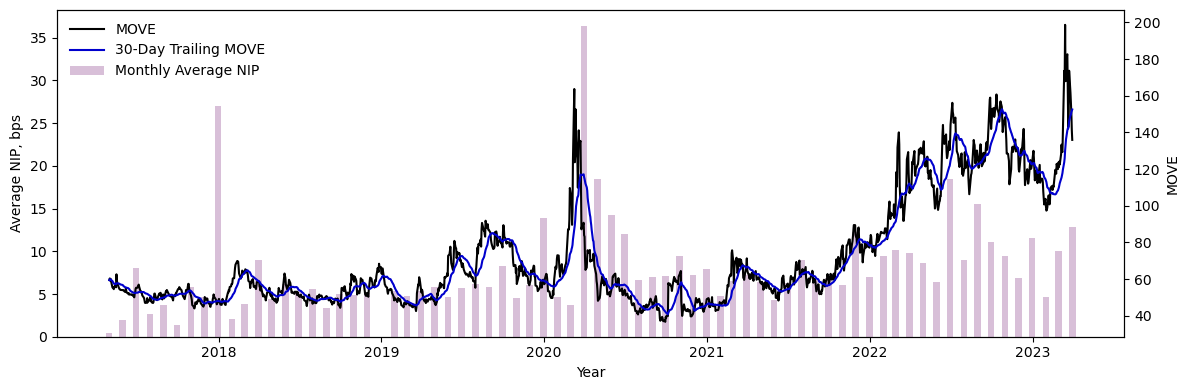

In [78]:
# Create a subplot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 4), dpi=100)

# Create a secondary y-axis on the right side for the monthly average NIP
ax2 = ax1.twinx()

# Plot the Monthly Average NIP data as a bar chart with light blue color and width of 15
avg_nip_bar = ax1.bar(monthly_avg.index, monthly_avg, color='thistle', width=15)
ax1.set_ylabel('Average NIP, bps')

# Plot the MOVE values as a line with red color using the left y-axis
move_line, = ax2.plot(move_values.index, move_values, label='MOVE', color='black')

# Plot the Trailing MOVE values as another line with blue color using the left y-axis
trailing_move_line, = ax2.plot(move_values_trailing.index, move_values_trailing, label='Trailing MOVE', color='mediumblue')
ax2.set_ylabel('MOVE')

# Combine the legends from both axes to show them together in the plot
lines = [move_line, trailing_move_line, avg_nip_bar]
labels = ['MOVE', '30-Day Trailing MOVE', 'Monthly Average NIP']
legend = ax1.legend(lines, labels, loc='upper left', handlelength=2.5, labelspacing=0.5)

# Set the legend box to be transparent
legend.get_frame().set_alpha(0)

# Set x-axis label
ax1.set_xlabel('Year')

# Adjust the layout to prevent overlap
fig.tight_layout()

# Save the plot as an image
# plt.savefig('move_trailing_nip.png', facecolor='w', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


## 2.9.3 Index returns

In [79]:
iboxx_overall_ret = iboxx_overall[['Download_Date', 'Daily_excess_return_over_sovereigns']].copy()
iboxx_overall_ret['Download_Date'] = pd.to_datetime(iboxx_overall_ret['Download_Date'])

In [80]:
iboxx_overall_ret.set_index('Download_Date', inplace=True)

In [81]:
iboxx_overall_ret['1M_Momentum'] = iboxx_overall_ret['Daily_excess_return_over_sovereigns'].rolling(window='30D').sum()

In [82]:
move_index_close['MOVERetsTrailing'] = move_index_close['CLOSE'].pct_change(periods=30)

In [83]:
move_trailing_rets = move_index_close.loc[start_date:end_date, 'MOVERetsTrailing']

In [84]:
ret_values = iboxx_overall_ret.loc[start_date:end_date, '1M_Momentum']

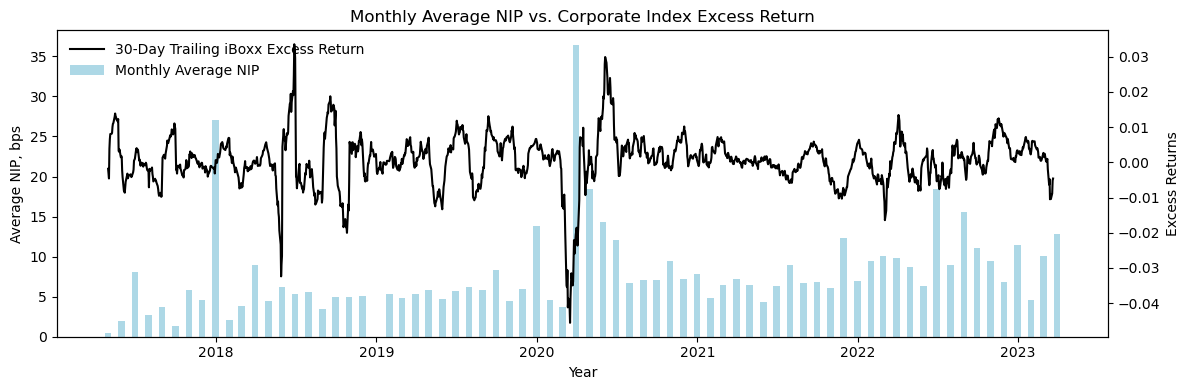

In [85]:
# Create a subplot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 4), dpi=100)

# Create a secondary y-axis on the right side for the monthly average NIP
ax2 = ax1.twinx()

# Plot the Monthly Average NIP data as a bar chart with light blue color and width of 15
avg_nip_bar = ax1.bar(monthly_avg.index, monthly_avg, color='lightblue', width=15)
ax1.set_ylabel('Average NIP, bps')

# Plot the Returns Over Sovereign as another line with blue color using the left y-axis
ret_line, = ax2.plot(ret_values.index, ret_values, label='30 Days Trailing Excess Returns', color='black')
ax2.set_ylabel('Excess Returns')

# Combine the legends from both axes to show them together in the plot
lines = [ret_line, avg_nip_bar]
labels = ['30-Day Trailing iBoxx Excess Return', 'Monthly Average NIP']
legend = ax1.legend(lines, labels, loc='upper left', handlelength=2.5, labelspacing=0.5)

# Set the legend box to be transparent
legend.get_frame().set_alpha(0)

# Set x-axis label
ax1.set_xlabel('Year')

# Add a title to the plot
ax1.set_title('Monthly Average NIP vs. Corporate Index Excess Return')

# Adjust the layout to prevent overlap
fig.tight_layout()

# Save the plot as an image
# plt.savefig('corp_excess_rets_nip.png', facecolor='w', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


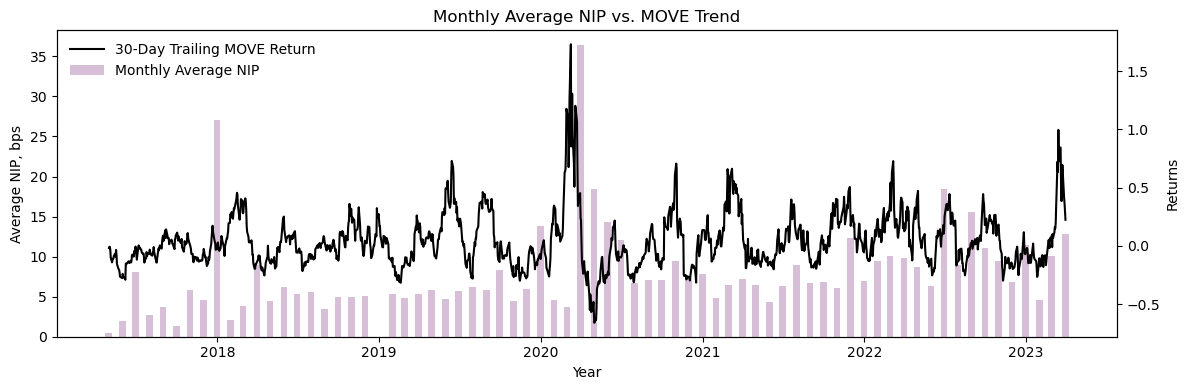

In [86]:
# Create a subplot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 4), dpi=100)

# Create a secondary y-axis on the right side for the monthly average NIP
ax2 = ax1.twinx()

# Plot the Monthly Average NIP data as a bar chart with light blue color and width of 15
avg_nip_bar = ax1.bar(monthly_avg.index, monthly_avg, color='thistle', width=15)
ax1.set_ylabel('Average NIP, bps')

# Plot the Returns Over Sovereign as another line with blue color using the left y-axis
move_trailing_rets_line, = ax2.plot(move_trailing_rets.index, move_trailing_rets, label='30 Days Trend MOVE', color='black')
ax2.set_ylabel('Returns')

# Combine the legends from both axes to show them together in the plot
lines = [move_trailing_rets_line, avg_nip_bar]
labels = ['30-Day Trailing MOVE Return', 'Monthly Average NIP']
legend = ax1.legend(lines, labels, loc='upper left', handlelength=2.5, labelspacing=0.5)

# Set the legend box to be transparent
legend.get_frame().set_alpha(0)

# Set x-axis label
ax1.set_xlabel('Year')

# Add a title to the plot
ax1.set_title('Monthly Average NIP vs. MOVE Trend')

# Adjust the layout to prevent overlap
fig.tight_layout()

# Save the plot as an image
# plt.savefig('move_trend_nip.png', facecolor='w', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# 3. Save datasets

In [87]:
nip_deals = nip_deals.sort_index()
nip_deals.index.names = ['date']
nip_deals.to_csv('new_issues_preprocessed.csv')

In [88]:
iboxx_overall_z.index.names = ['date']
iboxx_overall_z = iboxx_overall_z.rename(columns={'Z_Spread_Over_Libor': 'zSpread'})
iboxx_overall_z['zSpread'] = iboxx_overall_z['zSpread'] / 100
iboxx_overall_z.to_csv('zSpread.csv')

In [89]:
iboxx_overall_z_trailing = iboxx_overall_z.rolling('30D').mean()
iboxx_overall_z_trailing = iboxx_overall_z_trailing.rename(columns={'zSpread': 'zSpreadTrailing'})
iboxx_overall_z_trailing.to_csv('zSpreadTrailing30.csv')

In [90]:
iboxx_overall_ret_trailing = iboxx_overall_ret['Daily_excess_return_over_sovereigns'].rolling(window='30D').sum()
iboxx_overall_ret_trailing.index.names = ['date']
iboxx_overall_ret_trailing = pd.DataFrame(iboxx_overall_ret_trailing)
iboxx_overall_ret_trailing = iboxx_overall_ret_trailing.rename(columns={'Daily_excess_return_over_sovereigns': 'iboxxRetsTrailing'})
iboxx_overall_ret_trailing['iboxxRetsTrailing'] = iboxx_overall_ret_trailing['iboxxRetsTrailing'] * 100
iboxx_overall_ret_trailing.to_csv('retsTrailing30.csv')

In [91]:
move_index_close.index.names = ['date']
move_index_close = move_index_close.rename(columns={'CLOSE': 'MOVE'})
move_index_close['MOVE'] = move_index_close['MOVE'] / 100
move_index_close['MOVE'].to_csv('move.csv')

In [92]:
move_index_close_trailing = move_index_close.rolling('30D').mean()
move_index_close_trailing = move_index_close_trailing.rename(columns={'MOVE': 'MOVETrailing'})
move_index_close_trailing = move_index_close_trailing.drop(columns=['MOVERetsTrailing'])
move_index_close_trailing.to_csv('moveTrailing30.csv')

In [93]:
move_index_close_returns_df = move_index_close.dropna()
move_index_close_returns_df = move_index_close_returns_df.drop(columns=['MOVE'])
move_index_close_returns_df.to_csv('moveRetsTrailing30.csv')